<a href="https://colab.research.google.com/github/RichardMWarburton/ExploringCUAD/blob/Dev/Individual%20Clause%20Investigation%20-%20Gov%20Law.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Individual Clause Investigation

## The Data

CUAD: An Expert-Annotated NLP Dataset for Legal Contract Review

https://arxiv.org/abs/2103.06268

This code is an adaptation of the scrape.py file avaliable on the github repository for CUAD.  It has been adapted to run in Jypter notebooks and allow us to step throght the coding line by line.`

## 1: Import Packages & Define Useful Functions

In [71]:
from zipfile import ZipFile
import json
import os
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import re
from random import sample, choice
import numpy as np
import pandas as pd
import re
import string
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN, KMeans

In [4]:
def extract_zip(pth,data_pth = None):
    """Function to extract contents of a zip file to a specified location (wd if data_pth not passed)"""
    with ZipFile(pth, 'r') as zipObj:
       # Extract all the contents of zip file in different directory
       zipObj.extractall(data_pth)

## 2: Download repository and extract data

In [5]:
#Download CUAD git repository
if not os.path.exists('main.zip'):
  !wget --no-check-certificate https://github.com/TheAtticusProject/cuad/archive/refs/heads/main.zip
  !unzip -q main.zip

#If it has not already been extracted, extract the contents of data.zip
if not os.path.exists('cuad-main/data'):
  os.makedirs('cuad-main/data')

if not os.path.exists('cuad-main/data/CUADv1.json'):
  extract_zip('cuad-main/data.zip','cuad-main/data/')

#Download a manualy curated set of labels for the full CUAD data. 
if not os.path.exists('labels3.txt'):
  !wget https://raw.githubusercontent.com/RichardMWarburton/ExploringCUAD/main/labels3.txt

--2021-07-15 13:25:17--  https://github.com/TheAtticusProject/cuad/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/TheAtticusProject/cuad/zip/refs/heads/main [following]
--2021-07-15 13:25:17--  https://codeload.github.com/TheAtticusProject/cuad/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [  <=>               ]  17.77M  23.8MB/s    in 0.7s    

2021-07-15 13:25:18 (23.8 MB/s) - ‘main.zip’ saved [18631176]

--2021-07-15 13:25:19--  https://raw.githubusercontent.com/RichardMWarburton/ExploringCUAD/main/labels3.txt
Resolving raw.githubusercont

In [6]:
#Load CUADv1 JSON to data
with open('cuad-main/data/CUADv1.json','r') as infile:
    for line in infile:
        contract_data = json.loads(line)

### 2.1: Read in Label Data & Generate Look Up Dictionary

In [7]:
#Initate storage for labels look up (LU)
labels_LU = {}

#Read in labels data
with open('labels3.txt','r',encoding ='UTF-8') as infile:
  for line in infile:
    #Remove trailing special characters and split on tab
    data = line.strip().split(sep='\t')
    #Add name and label to labels_LU dictionary
    labels_LU[data[0]] = data[1]

The look up returns one error, most likely due to the accented E and a disparity of encoding.  This will be forced to 'Marketing Agreement' manually for now (EITHER SORT OR PROVIDE EXAMPLE)

### 2.2: Extract Raw Contract Data

In [8]:
#ser reg ex expression for characters to remove from contract contest
spec_chars = '\\n|\\t|\\t'

#Set number of contracts in data
num_contracts = len(contract_data['data'])

#Initate dictionary to store raw contract data
raw_contracts = defaultdict(list)

#for each contract
for i in range(num_contracts):
  #Append the title, contract text and character length of text to the raw_contracts dictionary
  raw_contracts['contract title'].append(contract_data['data'][i]['title'])
  raw_contracts['label'].append(labels_LU[contract_data['data'][i]['title']] if contract_data['data'][i]['title'] in labels_LU else 'marketing agreement' ) #<- manual error trap applied here (see below)
  
  #Parse raw text and process to remove breaks
  raw_text = contract_data['data'][i]['paragraphs'][0]['context']
  clean_text = re.sub(spec_chars,'',raw_text)

  #Split clean text in to sentances and tokens
  sentance_text = clean_text.split(sep = '. ')
  token_text = clean_text.split(sep = ' ')

  #Append text to the respective key in the raw_contracts dictionary
  raw_contracts['raw text'].append(raw_text)
  raw_contracts['clean text'].append(clean_text)
  raw_contracts['sentance text'].append(sentance_text)
  raw_contracts['token text'].append(token_text)
  
  #Add character, sentance and token counts to raw_contracts dictionary
  raw_contracts['character count'].append(len(raw_text))
  raw_contracts['sentance count'].append(len(sentance_text))
  raw_contracts['token count'].append(len(token_text))


In [9]:
#Sanity check value lists for each key ahve the correct length (510)
for key in raw_contracts:
  print(key,len(raw_contracts[key]))

contract title 510
label 510
raw text 510
clean text 510
sentance text 510
token text 510
character count 510
sentance count 510
token count 510


### 2.3: Extract Clause Specific Data

In [10]:
#Define the number of clauses
num_clauses = 41

#initate dictioanry to store caluse data
clause_data = defaultdict(list)

#For each contract
for i in range(num_contracts):
  #for each clause
  for j in range(num_clauses):
    #for each found clause annotation
    for k in range(len(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'])): 
      #Add the contract title
      clause_data['contract title'].append(contract_data['data'][i]['title'])
      clause_data['label'].append(labels_LU[contract_data['data'][i]['title']] if contract_data['data'][i]['title'] in labels_LU else 'marketing agreement' )  #<- manual error trap applied here
      clause_data['clause'].append(contract_data['data'][i]['paragraphs'][0]['qas'][j]['id'].split(sep='__')[1])
      clause_data['annotation'].append(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'][k]['text'])
      clause_data['annotation start'].append(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'][k]['answer_start'])
      clause_data['annotation length'].append(len(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'][k]['text']))


In [11]:
#Sanity check value lists for each key ahve the correct length (13823)
for key in clause_data:
  print(key,len(clause_data[key]))

contract title 13823
label 13823
clause 13823
annotation 13823
annotation start 13823
annotation length 13823


In [12]:
np.unique(clause_data['clause'])

array(['Affiliate License-Licensee', 'Affiliate License-Licensor',
       'Agreement Date', 'Anti-Assignment', 'Audit Rights',
       'Cap On Liability', 'Change Of Control',
       'Competitive Restriction Exception', 'Covenant Not To Sue',
       'Document Name', 'Effective Date', 'Exclusivity',
       'Expiration Date', 'Governing Law', 'Insurance',
       'Ip Ownership Assignment', 'Irrevocable Or Perpetual License',
       'Joint Ip Ownership', 'License Grant', 'Liquidated Damages',
       'Minimum Commitment', 'Most Favored Nation',
       'No-Solicit Of Customers', 'No-Solicit Of Employees',
       'Non-Compete', 'Non-Disparagement', 'Non-Transferable License',
       'Notice Period To Terminate Renewal', 'Parties',
       'Post-Termination Services', 'Price Restrictions', 'Renewal Term',
       'Revenue/Profit Sharing', 'Rofr/Rofo/Rofn', 'Source Code Escrow',
       'Termination For Convenience', 'Third Party Beneficiary',
       'Uncapped Liability', 'Unlimited/All-You-Can-Eat

## 3: Cleaning data and extracting a single clause

In [13]:
import string
#Initate dataframe of all clause data
clause_df = pd.DataFrame(clause_data)

#Convert to lower case
clause_df['annotation'] = clause_df['annotation'].apply(lambda x: x.lower())

#Remove any formating characters or multiple spaces and replace with a single space
clause_df['annotation'] = clause_df['annotation'].apply(lambda x: re.sub('\\t|\\r|\\n|[^\S]{2,}',' ',x))

#Remove punctuation from the string
clause_df['annotation'] = clause_df['annotation'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [14]:
#Define clause of interest
clause_of_interest = 'Governing Law'

#Limit df to clause of interest and extract annotations of itnerest
of_interest_data = clause_df[clause_df['clause'] == clause_of_interest]
annotations_of_interest = of_interest_data['annotation'].values

#Identify where there are multiple annotations per contract
titles,counts = np.unique(of_interest_data['contract title'],return_counts =True)
dups = titles[counts >= 2]

#Output Analysis
print('There are {} contracts with \'{}\' annotations'.format(*(titles.shape[0],clause_of_interest)))
print('There are {} contracts with more than one annotation'.format(dups.shape[0]))

There are 437 contracts with 'Governing Law' annotations
There are 25 contracts with more than one annotation


From the above we can see that: 

1.   Contracts may have multiple annotations for the same clause
2.   Not all contracts have an annotation of interest

Provisionally, we will look to concatinate all such annotations for a contract in to one string.  This will then represent all the salient points for the contract and clause in question.

In [15]:
#output duplicate annotations anc contract titles
dup_df = of_interest_data[of_interest_data['contract title'].isin(dups)][['contract title','annotation']]

#print sample of duplicate annotations
for i in dup_df.index[:8]:
  print(dup_df.loc[i,'contract title'])
  print(repr(dup_df.loc[i,'annotation']))
  #print(dup_df.loc[i,'annotation'].split(sep=' '))
  print('\n')

ChinaRealEstateInformationCorp_20090929_F-1_EX-10.32_4771615_EX-10.32_Content License Agreement
'this termination agreement shall be governed by the laws of the prc without regard to conflicts of law principles'


ChinaRealEstateInformationCorp_20090929_F-1_EX-10.32_4771615_EX-10.32_Content License Agreement
'this agreement and any dispute or claim arising out of or in connection with it or its subject matter shall be governed by and construed in accordance with the laws of the peoples republic of china without regard to its conflicts of laws rules that would mandate the application of the laws of another jurisdiction'


LOYALTYPOINTINC_11_16_2004-EX-10.2-RESELLER AGREEMENT
'this agreement shall be subject to and governed by the laws of the state of missouri usa'


LOYALTYPOINTINC_11_16_2004-EX-10.2-RESELLER AGREEMENT
'this agreement shall be deemed to have been made and executed in the state of missouri and any dispute arising thereunder shall be resolved in accordance with the laws o

THE ABOVE COULD BE OUT PUTTED BETTER

In [16]:
#Initate memory for annotations within contracts
combined_annotations_list = defaultdict(list)
combined_annotations_string = {}

#For each annotation of interest found in the contract, 
#append annotation to a default dict list with contract as key
for i in of_interest_data.index:
  name = of_interest_data.loc[i,['contract title']].values[0]
  annotation = of_interest_data.loc[i,['annotation']].values[0]
  combined_annotations_list[name].append(annotation)

#Produce a singel string of all annotations found in specific contracts
for key in combined_annotations_list.keys():
  combined_annotations_string[key] = ' '.join(combined_annotations_list[key])

In [17]:
#Build array of contract names and concatenated annotations
contracts = np.array(list(combined_annotations_string.keys()))
combined_annotations = np.array(list(combined_annotations_string.values()))

## Section 4: Vectorizing Single Clause Data & Visualising

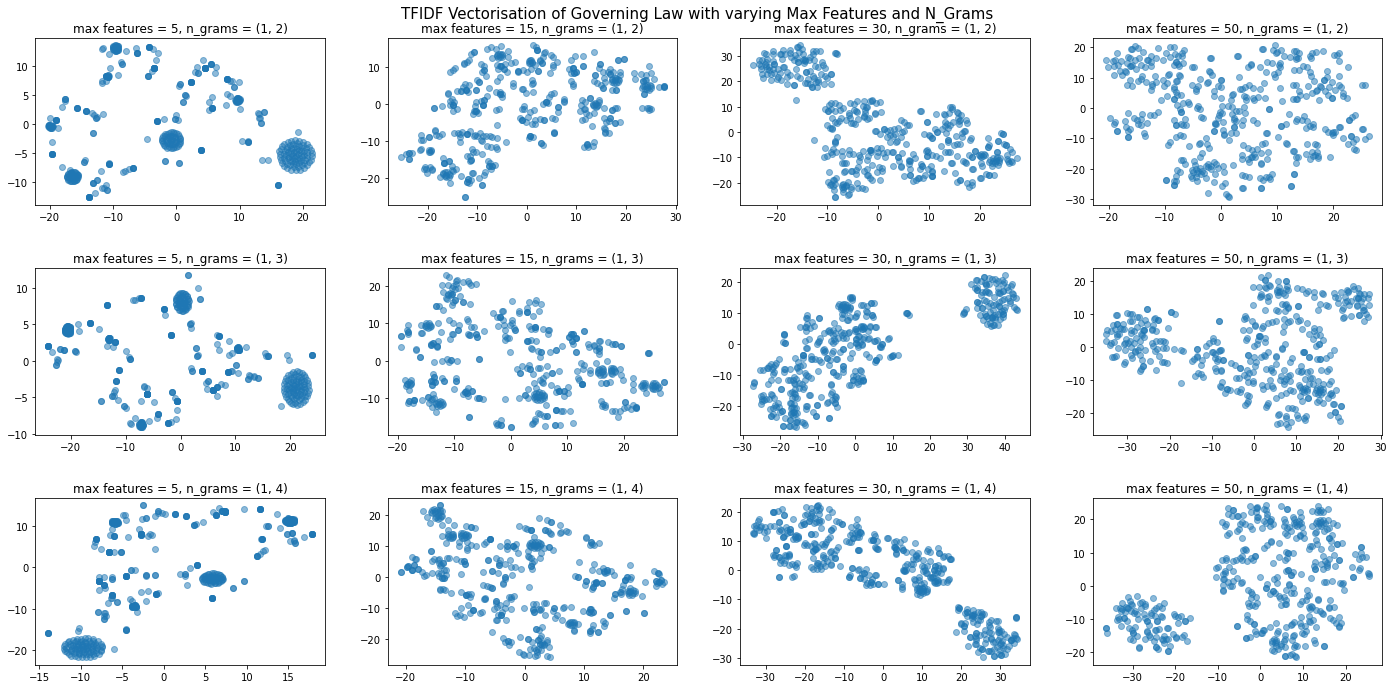

In [68]:
#Define max feature and n_gram ranges
max_features = [5,15,30,50]
n_grams = [(1,2),(1,3),(1,4)]

#Initate plot
fig, axs = plt.subplots(len(n_grams),len(max_features), figsize = (20,10))

#For each pair of max_features and n_grams
for i in range(len(max_features)):
  for j in range(len(n_grams)):

    #TFIDF vectorize the annotation
    vectorizer = TfidfVectorizer(ngram_range = n_grams[j],stop_words ='english',max_features=max_features[i])
    X = vectorizer.fit_transform(combined_annotations).toarray()  

    #Reduce dimension wiht TSNE to 2D
    X_tsne = TSNE(n_components=2).fit_transform(X)
    x = X_tsne[:,0]
    y = X_tsne[:,1]

    #Plot respective parameters
    axs[j,i].scatter(x, y, alpha = 0.5)
    axs[j,i].set_title('max features = {}, n_grams = {}'.format(*(max_features[i],n_grams[j])))

#Format plot
plt.tight_layout(pad=3.0)
plt.suptitle('TFIDF Vectorisation of {} with varying Max Features and N_Grams\n\n'.format(clause_of_interest),size = 15)
plt.show()

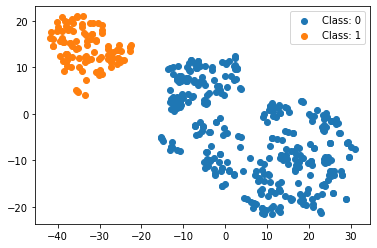

In [125]:
from sklearn.cluster import AgglomerativeClustering

selected_max_features = 30
selected_n_gram = (1,4)

vectorizer = TfidfVectorizer(ngram_range = selected_n_gram,stop_words ='english',max_features=selected_max_features)
X = vectorizer.fit_transform(combined_annotations).toarray()  

#Reduce dimension wiht TSNE to 2D
X_tsne = TSNE(n_components=2).fit_transform(X)

#Fit agglomerative clister model with two clusters to split groups
cluster = AgglomerativeClustering(n_clusters=2).fit(X_tsne)

x = X_tsne[:,0]
y = X_tsne[:,1]
labels = cluster.labels_

for i in np.unique(labels):
  idx = labels == i
  plt.scatter(x[idx],y[idx],label = 'Class: {}'.format(str(i)))

plt.legend()
plt.show()

In [180]:
#Define number of random samples to return
n=5

#For each clustered class
for i in np.unique(labels):
  #Initate counters
  ny_count = 0
  new_count = 0

  #identify class indicies
  idx = labels == i

  #Obtain class data via indicies
  cluster_data = combined_annotations[idx]

  #For each annotation in the class data
  for annotation in cluster_data:
    
    #Count if 'New York' is in the annotation
    if 'new york' in annotation:
      ny_count += 1
    
    #Count if 'New' is in the annotations
    if 'new' in annotation:
      new_count += 1

  #Return n random annotaitons from cluster data
  rnd_samples = np.random.choice(cluster_data,n)
  
  #Outout random samples and summary data
  print('*'*75+'\n')
  print('Class Random Samples:',str(i),'\n')
  for smp in rnd_samples:
    print(smp)
  print('\nClass Analysis:',str(i))
  print('\nThere are {} instances where \'new\' is in the annotation ({:.2%})'.format(*(new_count,new_count/len(cluster_data))))
  print('There are {} instances where \'new york\' is in the annotation ({:.2%})\n'.format(*(ny_count,ny_count/len(cluster_data))))
print('*'*75) 

***************************************************************************

Class Random Samples: 0 

this agreement shall be governed by and construed and enforced in accordance with the substantive laws of the state of delaware without regard to any conflicts of law provisions thereof that would result in the application of the laws of any other jurisdiction
this agreement takes effect upon its acceptance and execution by airsopure in the state of texas and shall be interpreted and construed under the laws of the state of texas
this agreement the legal relations between the parties and any action whether contractual or noncontractual instituted by any party with respect to matters arising under or growing out of or in connection with or in respect of this agreement shall be governed by and construed in accordance with the internal laws of the state of arizona usa excluding any choice of law rules that may direct the application of the laws of another jurisdiction and except that que